In [1]:
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import string
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from glob import glob
import os
import json
import errno

font = {'weight': 'normal', 'family': 'DejaVu Sans'}

plt.rc('text', usetex=True)
plt.rc('font', **font)
plt.rcParams['font.size'] = 24
#plt.rcParams['axes.linewidth'] = 1.2



class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        
        center = 0.8 * width, 0.4 * height
        p = mpatches.Circle(xy=center, radius = 8)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def get_maxfolder(folder, add_str = ''):
    
    lst = glob(os.path.join(os.getcwd(), 
                            folder, 
                            add_str,
                            "*", 
                            ""))
    max_num = 0
    for st in lst:
        try:
            num = int(st.split('/')[-2].split('_')[-1])
            
            if num > max_num :
                max_num = num
                      
        except Exception as e:
            pass
                      
    new_num = max_num
    return new_num
    
def create_dir(folder, batch = 0, add_str = ''):
    
    start = False
    if (batch == 0):
        new_num = get_maxfolder(folder, add_str = add_str) + 1
        mydir = os.path.join(os.getcwd(), 
                             folder,
                             add_str,
                             'batch_%d' % (new_num))
        
        if(new_num == 1):
            start = True
    else:
        mydir = os.path.join(os.getcwd(), 
                             folder,
                             add_str,
                             'batch_%d' % batch)
    
    try:
        os.makedirs(mydir)
        
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            
    return mydir, start

def save_fig(figs, folder, figname, **params):

    sim_folder, _ = create_dir('%s/' % folder, add_str = figname)
    
    data = dict()
    if ('data' in params):
        data = params['data']
        params.pop('data', None)
        
        np.savez('%s/%s_data' % (sim_folder, figname), **params, **data)

    if (type(figs) is list):
        for q, fig in enumerate(figs):
            fig.savefig('%s/%s_%d.svg' % (sim_folder, figname, q), bbox_inches = 'tight')
            fig.savefig('%s/%s_%d.pdf' % (sim_folder, figname, q), bbox_inches = 'tight')
            fig.savefig('%s/%s_%d.png' % (sim_folder, figname, q), bbox_inches = 'tight', dpi = 300)
    else:
        figs.savefig('%s/%s.svg' % (sim_folder, figname), bbox_inches = 'tight')
        figs.savefig('%s/%s.pdf' % (sim_folder, figname), bbox_inches = 'tight')
        figs.savefig('%s/%s.png' % (sim_folder, figname), bbox_inches = 'tight', dpi = 300)
      
    if not params:
        return
    
    for key in params:
        
        if (type(params[key]) is np.ndarray):
            params[key] = params[key].astype(float).tolist()
        elif (type(params[key]) is not list):
            params[key] = float(params[key])
        
    json_params = open('%s/%s_params.json' % (sim_folder, figname), "w")
    json.dump(params, json_params)
    json_params.close()

In [2]:
def simulate(sigv, l, m, sig, gamma, phi, nu, q = 2, kick = 0.2, snapshots = [1, 3, 9]):
    
    prng = np.random.RandomState()
    dim = 2
    
    burn = 0
    
    xp = []
    alive = [[] for i in range(l + burn + 1)]
    xv = prng.normal(kick, sigv/np.sqrt(dim), size = (l + 1 + burn,dim))
    xv[0,:] = 0

    dx = np.zeros(dim)
    snapshots = np.array(snapshots) + burn
    snaps = []
    
    for j in range(l + burn):
        current = []

        if j in snapshots:
            snap = []
            for i in alive[j]:
                snap.append(np.copy(xp[i]))

            snaps.append(snap)
        
            
        for i in range(len(xp)):
            for n in range(dim):
                xp[i][n] -= dx[n]
                
        for snap in snaps:
            for i in range(len(snap)):
                for n in range(dim):
                    snap[i][n] -= dx[n]
                    
        for i in alive[j]:
   
            k = int(prng.binomial(xp[i][dim], gamma))
            xp[i][dim] = k
            
            if( k > 0):
                alive[j+1].append(i)
                
        for i in alive[j+1]:
            
            d = 0
            for n in range(dim):
                d += xp[i][n]**2
                
            d = np.sqrt(d)
            k = int(prng.binomial(xp[i][dim], nu*np.exp(-d**q)))
            xp[i][dim] += k
            

    
        sp = prng.poisson(m)
        sp = 1
        ini_xp = len(xp)
        
        for k in range(sp):
            xp.append(np.append(prng.normal(0, sig/np.sqrt(dim), size = dim), [1, ini_xp + k]))
            alive[j+1].append(ini_xp + k)
                      
                      
        for n in range(dim):
            dx[n] = xv[j+1,n]
           
       
    z = np.cumsum(xv[:-1], axis = 0)
    z = z - z[-1, :]
    
    snaps_xv = []
    
    for i in snapshots:
        snaps_xv.append(z[:i,:])
    
   
    return snaps, snaps_xv

<ipython-input-2-1932dbe68856>:52: RuntimeWarning: overflow encountered in double_scalars
  k = int(prng.binomial(xp[i][dim], nu*np.exp(-d**q)))


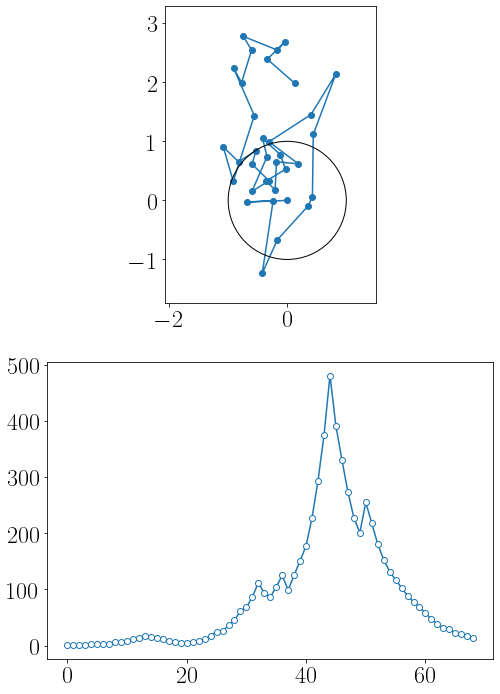

In [73]:
fig, (ax1, ax2) = plt.subplots(figsize = (8, 2*6), ncols = 1, nrows = 2)

q = 1000
sigv = 0.5
sig = 0
m = 1
gamma = 0.85
phi = 100
nu = 0.5

n_max = 0

while n_max < 50:
    snaps, snaps_xv = simulate(sigv, 70, m, 
                               sig, gamma, phi, nu, q = 1000, kick = 0.0,
                               snapshots = np.arange(1, 70))

    xp = np.array(snaps[-1])
    xv = snaps_xv[-1]

    first = 0
    n_traj = np.zeros(len(snaps))

    for j in range(len(snaps)):
    
        xp_temp = np.array(snaps[j])
        a = np.argwhere(xp_temp[:,3] == first).flatten()
    
        if(len(a) == 1):
            n_traj[j] = xp_temp[a, 2]
        
    n_max = max(n_traj)
    

dx = xv[0,0]
dy = xv[0,1]

ax1.plot(xv[::2,0] - dx, xv[::2,1] - dy, '-o')

immune_mem = plt.Circle((0, 0), 1, 
                        facecolor = 'None', 
                        edgecolor = 'k',
                        zorder = 9)

xmin = min(np.min(xv[:,0] - dx) - 0.5, -1.5)
xmax = max(np.max(xv[:,0] - dx) + 0.5, 1.5)
ymin = min(np.min(xv[:,1] - dy) - 0.5, -1.5)
ymax = max(np.max(xv[:,1] - dy) + 0.5, 1.5)

ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])

ax1.add_artist(immune_mem)
ax1.set_aspect('equal')
ax2.plot(n_traj, '-o', markersize = 6,
         markerfacecolor = 'w')


plt.show()

In [47]:
data = dict(xv = xv,
            xp = xp,
            n_traj = n_traj)

save_fig(fig, './', 'sketch',
         q = q, sigv = sigv, 
         gamma = gamma, nu = nu, 
         m = 1, data = data)